In [ ]:
#%env CUDA_VISIBLE_DEVICES=3

In [9]:
import torch

In [10]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [11]:
from era_data import TabletEraDataset
from era_model import EraClassifier
from glob import glob
from era_data import TabletPeriodDataset
import pandas as pd
from matplotlib import pyplot as plt
from itertools import islice
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
from tqdm.auto import tqdm, trange
import numpy as np
import seaborn as sns
from torch.utils.data import DataLoader
from sklearn.linear_model import LogisticRegression

# Load data and model

In [13]:
VERSION_NAME = 'period_clf_bs16_lr5e-05_5epochs-resnet50-97640_samples-preprocessed2'

IMG_DIR = 'output/images_preprocessed'

In [15]:
CKPT_FN = glob(f'lightning_logs/{VERSION_NAME}/checkpoints/*')[0]
CKPT_FN

'lightning_logs/period_clf_bs16_lr5e-05_5epochs-resnet50-97640_samples-preprocessed2/checkpoints/epoch=4-step=30358.ckpt'

In [16]:
num_classes = len(TabletPeriodDataset.PERIOD_INDICES) + 2
num_classes

24

In [17]:
%time model = EraClassifier.load_from_checkpoint(CKPT_FN, num_classes=num_classes)

CPU times: user 647 ms, sys: 277 ms, total: 924 ms
Wall time: 680 ms


In [18]:
model.to(device);

In [19]:
model.eval();

In [20]:
train_ids = pd.read_csv(f'output/clf_ids/period-train-{VERSION_NAME}.csv', header=None)[0].astype(str)
test_ids = pd.read_csv(f'output/clf_ids/period-test-{VERSION_NAME}.csv', header=None)[0].astype(str)

In [21]:
len(train_ids), len(test_ids)

(97140, 500)

In [22]:
ds_train = TabletPeriodDataset(IDS=train_ids,IMG_DIR=IMG_DIR)
ds_test = TabletPeriodDataset(IDS=test_ids, IMG_DIR=IMG_DIR)

Filtering 97640 IDS down to provided 97140...
Filtering 97640 IDS down to provided 500...


# Calculate predictions

In [23]:
from itertools import islice
import scipy

In [24]:
import numpy as np
from PIL import Image

def collate_fn(batch):
    # Unsqueeze the matrix (the first element of each tuple)
    
    unsqueezed_data = [torch.from_numpy(np.array(Image.fromarray(sample[0]).resize((178, 218), Image.NEAREST))).unsqueeze(0) for sample in batch]
    labels = torch.from_numpy(np.array([sample[1] for sample in batch]))

    # Concatenate the unsqueezed matrices into a new tensor
    unsqueezed_batch_data = torch.cat(unsqueezed_data, dim=0)

    return unsqueezed_batch_data, labels

In [25]:
# dl_train = DataLoader(ds_train, batch_size=16, shuffle=False, num_workers=1)
dl_test = DataLoader(ds_test, batch_size=16, collate_fn = collate_fn, shuffle=False, num_workers=1)

In [28]:
def dl2data(dl, MAX_N=None, device='cuda'):
    logits = []
    y_true = []  # This will hold the period indices
    model.eval()  # Set the model to evaluation mode

    with torch.no_grad():
        gen = tqdm(islice(dl, MAX_N), total=(MAX_N if MAX_N is not None else len(dl)))
        for img, period_index in gen:
            try:
                y_true.append(period_index.cpu().numpy())  # Append period indices
                logits.append(model(img.to(device)).cpu().numpy())  # Process the image through the model
            except Exception as e:
                print(f"Error processing batch: {e}")

    y_true = np.hstack(y_true)
    logits = np.vstack(logits)

    return logits, y_true

In [29]:
logits, y_true = dl2data(dl_test)

  0%|          | 0/31 [00:00<?, ?it/s]

In [30]:
y_true.shape, logits.shape

((489,), (489, 24))

In [31]:
y_pred = logits.argmax(axis=-1)
y_prob = scipy.special.softmax(logits, axis=-1)

In [32]:
y_pred.shape, y_prob.shape

((489,), (489, 24))

In [33]:
(y_pred == y_true).mean()

0.8282208588957055

# Check metrics

In [34]:
from collections import Counter

In [35]:
EARLY_BRONZE = {
    'Old Akkadian', 'Ur III',
    'ED IIIb', 'Uruk III',
    'Proto-Elamite', 'Lagash II',
    'Ebla', 'ED IIIa', 'ED I-II',
    'Uruk IV', 'Linear Elamite',
    'Harappan'
    
}
MID_LATE_BRONZE = {
    'Early Old Babylonian',
    'Old Babylonian', 'Old Assyrian',
    'Middle Babylonian', 'Middle Assyrian',
    'Middle Elamite', 'Middle Hittite'
}
IRON = {
    'Neo-Babylonian', 'Neo-Assyrian',
    'Achaemenid', 'Hellenistic',
    'Neo-Elamite'
}
ERA_MAP = {
    **{K: 'EB' for K in EARLY_BRONZE},
    **{K: 'MLB' for K in MID_LATE_BRONZE},
    **{K: 'I' for K in IRON},
}

In [36]:
def explain(period):
    return f'{period} ({ERA_MAP.get(period, "?")})'
explain('Neo-Babylonian')

'Neo-Babylonian (I)'

In [37]:
idx2period = {v: k for k, v in TabletPeriodDataset.PERIOD_INDICES.items()}
idx2period[0] = 'other'

In [38]:
idx2period[0], idx2period[5]

('other', 'Neo-Babylonian')

In [39]:
indices = list(set(y_true) | set(y_pred))
print(len(indices))
print(indices)
PERIOD_LABELS = [explain(idx2period[i]) for i in indices]
print(PERIOD_LABELS)

19
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 14, 15, 17, 19, 20, 21]
['other (?)', 'Ur III (EB)', 'Neo-Assyrian (I)', 'Old Babylonian (MLB)', 'Middle Babylonian (MLB)', 'Neo-Babylonian (I)', 'Old Akkadian (EB)', 'Achaemenid (I)', 'Early Old Babylonian (MLB)', 'ED IIIb (EB)', 'Middle Assyrian (MLB)', 'Old Assyrian (MLB)', 'Uruk III (EB)', 'Lagash II (EB)', 'Ebla (EB)', 'Hellenistic (I)', 'Middle Elamite (MLB)', 'Middle Hittite (MLB)', 'Uruk IV (EB)']


In [40]:
print(classification_report(y_true, y_pred, target_names=PERIOD_LABELS))

                            precision    recall  f1-score   support

                 other (?)       1.00      0.33      0.50         3
               Ur III (EB)       0.96      0.94      0.95       140
          Neo-Assyrian (I)       0.96      0.97      0.97       109
      Old Babylonian (MLB)       0.71      0.87      0.78        91
   Middle Babylonian (MLB)       0.58      0.51      0.55        35
        Neo-Babylonian (I)       0.58      0.48      0.52        23
         Old Akkadian (EB)       0.80      0.67      0.73        18
            Achaemenid (I)       0.86      0.60      0.71        10
Early Old Babylonian (MLB)       0.75      0.33      0.46         9
              ED IIIb (EB)       0.79      0.73      0.76        15
     Middle Assyrian (MLB)       0.67      0.50      0.57         8
        Old Assyrian (MLB)       0.85      0.92      0.88        12
             Uruk III (EB)       1.00      0.60      0.75         5
            Lagash II (EB)       0.80      0.80

/home/kapond/.conda/envs/dani_torch/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/kapond/.conda/envs/dani_torch/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/kapond/.conda/envs/dani_torch/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [41]:
# let's just use classes with support >=10, everything else goes to 0: other
COMMON_LABELS = list({k for k, v in Counter(y_true).items() if v >= 10})
print(f'Common labels: ({len(COMMON_LABELS)})')
[(i, explain(idx2period[i])) for i in COMMON_LABELS]

Common labels: (9)


[(1, 'Ur III (EB)'),
 (2, 'Neo-Assyrian (I)'),
 (3, 'Old Babylonian (MLB)'),
 (4, 'Middle Babylonian (MLB)'),
 (5, 'Neo-Babylonian (I)'),
 (6, 'Old Akkadian (EB)'),
 (7, 'Achaemenid (I)'),
 (9, 'ED IIIb (EB)'),
 (11, 'Old Assyrian (MLB)')]

In [42]:
y_true_c = y_true.copy()
y_true_c[~np.isin(y_true, COMMON_LABELS)] = 0
print((~np.isin(y_true, COMMON_LABELS)).mean(), 'changed to "other"')

0.0736196319018405 changed to "other"


In [43]:
y_pred_c = y_pred.copy()
y_pred_c[~np.isin(y_pred, COMMON_LABELS)] = 0
print((~np.isin(y_pred, COMMON_LABELS)).mean(), 'changed to "other"')

0.06339468302658487 changed to "other"


In [44]:
indices_c = list(set(y_true_c) | set(y_pred_c))
print(len(indices_c))
print(indices_c)
PERIOD_LABELS_C = [explain(idx2period[i]) for i in indices_c]
print(PERIOD_LABELS_C)

10
[0, 1, 2, 3, 4, 5, 6, 7, 9, 11]
['other (?)', 'Ur III (EB)', 'Neo-Assyrian (I)', 'Old Babylonian (MLB)', 'Middle Babylonian (MLB)', 'Neo-Babylonian (I)', 'Old Akkadian (EB)', 'Achaemenid (I)', 'ED IIIb (EB)', 'Old Assyrian (MLB)']


In [45]:
print(classification_report(y_true_c, y_pred_c, target_names=PERIOD_LABELS_C))

                         precision    recall  f1-score   support

              other (?)       0.74      0.64      0.69        36
            Ur III (EB)       0.96      0.94      0.95       140
       Neo-Assyrian (I)       0.96      0.97      0.97       109
   Old Babylonian (MLB)       0.71      0.87      0.78        91
Middle Babylonian (MLB)       0.58      0.51      0.55        35
     Neo-Babylonian (I)       0.58      0.48      0.52        23
      Old Akkadian (EB)       0.80      0.67      0.73        18
         Achaemenid (I)       0.86      0.60      0.71        10
           ED IIIb (EB)       0.79      0.73      0.76        15
     Old Assyrian (MLB)       0.85      0.92      0.88        12

               accuracy                           0.83       489
              macro avg       0.78      0.73      0.75       489
           weighted avg       0.84      0.83      0.83       489



In [46]:
cm = confusion_matrix(y_true_c, y_pred_c)
cm # rows: ground truth; cols: prediction

array([[ 23,   0,   1,   6,   2,   2,   1,   0,   0,   1],
       [  0, 131,   1,   5,   1,   0,   0,   0,   1,   1],
       [  0,   1, 106,   1,   0,   0,   0,   0,   1,   0],
       [  1,   4,   1,  79,   3,   3,   0,   0,   0,   0],
       [  0,   1,   1,  13,  18,   1,   0,   1,   0,   0],
       [  4,   0,   0,   3,   5,  11,   0,   0,   0,   0],
       [  1,   0,   0,   2,   1,   1,  12,   0,   1,   0],
       [  2,   0,   0,   0,   1,   1,   0,   6,   0,   0],
       [  0,   0,   0,   2,   0,   0,   2,   0,  11,   0],
       [  0,   0,   0,   1,   0,   0,   0,   0,   0,  11]])

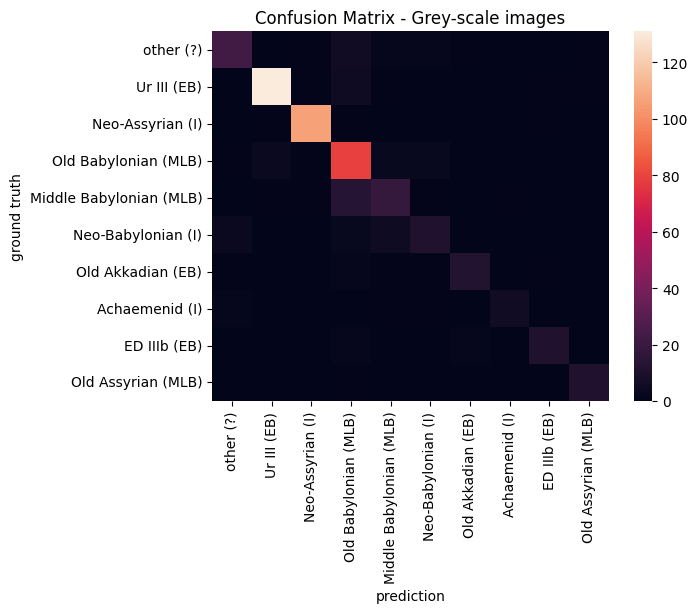

In [67]:
sns.heatmap(cm, xticklabels=PERIOD_LABELS_C, yticklabels=PERIOD_LABELS_C);
plt.xlabel('prediction');
plt.ylabel('ground truth')
plt.title("Confusion Matrix - Grey-scale images");

In [48]:
cm_rownorm = (cm / cm.sum(axis=1)[:, None])

In [49]:
cm

array([[ 23,   0,   1,   6,   2,   2,   1,   0,   0,   1],
       [  0, 131,   1,   5,   1,   0,   0,   0,   1,   1],
       [  0,   1, 106,   1,   0,   0,   0,   0,   1,   0],
       [  1,   4,   1,  79,   3,   3,   0,   0,   0,   0],
       [  0,   1,   1,  13,  18,   1,   0,   1,   0,   0],
       [  4,   0,   0,   3,   5,  11,   0,   0,   0,   0],
       [  1,   0,   0,   2,   1,   1,  12,   0,   1,   0],
       [  2,   0,   0,   0,   1,   1,   0,   6,   0,   0],
       [  0,   0,   0,   2,   0,   0,   2,   0,  11,   0],
       [  0,   0,   0,   1,   0,   0,   0,   0,   0,  11]])

In [50]:
cm_rownorm

array([[0.63888889, 0.        , 0.02777778, 0.16666667, 0.05555556,
        0.05555556, 0.02777778, 0.        , 0.        , 0.02777778],
       [0.        , 0.93571429, 0.00714286, 0.03571429, 0.00714286,
        0.        , 0.        , 0.        , 0.00714286, 0.00714286],
       [0.        , 0.00917431, 0.97247706, 0.00917431, 0.        ,
        0.        , 0.        , 0.        , 0.00917431, 0.        ],
       [0.01098901, 0.04395604, 0.01098901, 0.86813187, 0.03296703,
        0.03296703, 0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.02857143, 0.02857143, 0.37142857, 0.51428571,
        0.02857143, 0.        , 0.02857143, 0.        , 0.        ],
       [0.17391304, 0.        , 0.        , 0.13043478, 0.2173913 ,
        0.47826087, 0.        , 0.        , 0.        , 0.        ],
       [0.05555556, 0.        , 0.        , 0.11111111, 0.05555556,
        0.05555556, 0.66666667, 0.        , 0.05555556, 0.        ],
       [0.2       , 0.        , 0.       

In [51]:
cm.sum(axis=1)

array([ 36, 140, 109,  91,  35,  23,  18,  10,  15,  12])

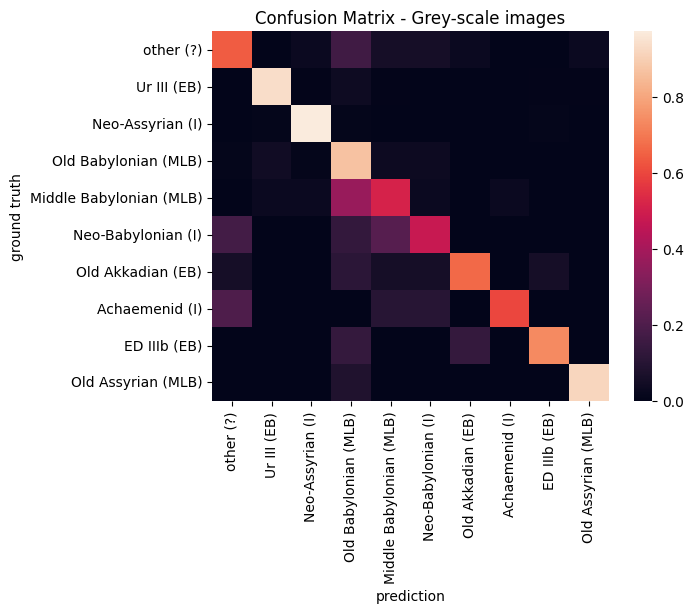

In [68]:
sns.heatmap(cm_rownorm, xticklabels=PERIOD_LABELS_C, yticklabels=PERIOD_LABELS_C);
plt.xlabel('prediction');
plt.ylabel('ground truth')
plt.title("Confusion Matrix - Grey-scale images");

In [53]:
cm_df = pd.DataFrame(cm, columns=PERIOD_LABELS_C, index=PERIOD_LABELS_C)
cm_df

,other (?),Ur III (EB),Neo-Assyrian (I),Old Babylonian (MLB),Middle Babylonian (MLB),Neo-Babylonian (I),Old Akkadian (EB),Achaemenid (I),ED IIIb (EB),Old Assyrian (MLB)
other (?),23,0,1,6,2,2,1,0,0,1
Ur III (EB),0,131,1,5,1,0,0,0,1,1
Neo-Assyrian (I),0,1,106,1,0,0,0,0,1,0
Old Babylonian (MLB),1,4,1,79,3,3,0,0,0,0
Middle Babylonian (MLB),0,1,1,13,18,1,0,1,0,0
Neo-Babylonian (I),4,0,0,3,5,11,0,0,0,0
Old Akkadian (EB),1,0,0,2,1,1,12,0,1,0
Achaemenid (I),2,0,0,0,1,1,0,6,0,0
ED IIIb (EB),0,0,0,2,0,0,2,0,11,0
Old Assyrian (MLB),0,0,0,1,0,0,0,0,0,11


In [54]:
cm_rn_df = pd.DataFrame(cm_rownorm, columns=PERIOD_LABELS_C, index=PERIOD_LABELS_C)
cm_rn_df

,other (?),Ur III (EB),Neo-Assyrian (I),Old Babylonian (MLB),Middle Babylonian (MLB),Neo-Babylonian (I),Old Akkadian (EB),Achaemenid (I),ED IIIb (EB),Old Assyrian (MLB)
other (?),0.638889,0.000000,0.027778,0.166667,0.055556,0.055556,0.027778,0.000000,0.000000,0.027778
Ur III (EB),0.000000,0.935714,0.007143,0.035714,0.007143,0.000000,0.000000,0.000000,0.007143,0.007143
Neo-Assyrian (I),0.000000,0.009174,0.972477,0.009174,0.000000,0.000000,0.000000,0.000000,0.009174,0.000000
Old Babylonian (MLB),0.010989,0.043956,0.010989,0.868132,0.032967,0.032967,0.000000,0.000000,0.000000,0.000000
Middle Babylonian (MLB),0.000000,0.028571,0.028571,0.371429,0.514286,0.028571,0.000000,0.028571,0.000000,0.000000
Neo-Babylonian (I),0.173913,0.000000,0.000000,0.130435,0.217391,0.478261,0.000000,0.000000,0.000000,0.000000
Old Akkadian (EB),0.055556,0.000000,0.000000,0.111111,0.055556,0.055556,0.666667,0.000000,0.055556,0.000000
Achaemenid (I),0.200000,0.000000,0.000000,0.000000,0.100000,0.100000,0.000000,0.600000,0.000000,0.000000
ED IIIb (EB),0.000000,0.000000,0.000000,0.133333,0.000000,0.000000,0.133333,0.000000,0.733333,0.000000
Old Assyrian (MLB),0.000000,0.000000,0.000000,0.083333,0.000000,0.000000,0.000000,0.000000,0.000000,0.916667


In [55]:
cm_df.loc['Early Old Babylonian (MLB)']

KeyError: 'Early Old Babylonian (MLB)'

In [ ]:
cm_rn_df.loc['Early Old Babylonian (MLB)']

# Hierarchical clustering on confusion matrix

In [ ]:
from scipy.cluster import hierarchy

In [ ]:
Y = hierarchy.distance.pdist(cm_rownorm, metric='euclidean')

In [ ]:
Z = hierarchy.linkage(Y, method='single')

In [ ]:
ax = hierarchy.dendrogram(Z, show_contracted=True, labels=PERIOD_LABELS_C, orientation='right')

# Clustering feature vectors using model as feature extractor

In [ ]:
from sklearn.manifold import TSNE, Isomap
import matplotlib.pyplot as plt

In [ ]:
activation = {}
def get_activation(name):
    def hook(model, inp, output):
        activation[name] = output.detach()
    return hook

In [ ]:
model.core.avgpool.register_forward_hook(get_activation('ap'))
# model.core.fc.register_forward_hook(get_activation('fc'))

In [ ]:
dl_test = DataLoader(ds_test, batch_size=16, shuffle=False, num_workers=1)

In [ ]:
def extract_features(dl, MAX_N=None):
    outs = []
    with torch.no_grad():
        gen = tqdm(dl) if MAX_N is None else tqdm(islice(dl, MAX_N), total=MAX_N)
        for X, y in gen:
            model(X.to(device))
            outs.append(activation['ap'].cpu().numpy()[..., 0, 0])
    return np.vstack(outs)
#     y_true = np.hstack(y_true)
#     logits = np.vstack(logits)
#     return logits, y_true

In [ ]:
feats = extract_features(dl_test)

In [ ]:
feats.shape

In [ ]:
%time F = TSNE(n_components=2, init='pca').fit_transform(feats)
# learning_rate='auto' -- https://www.pythonfixing.com/2021/11/fixed-sklearnmanifoldtsne-typeerror.html

In [ ]:
%time F2 = Isomap(n_components=2).fit_transform(feats)

In [56]:
F.shape

NameError: name 'F' is not defined

NameError: name 'F' is not defined

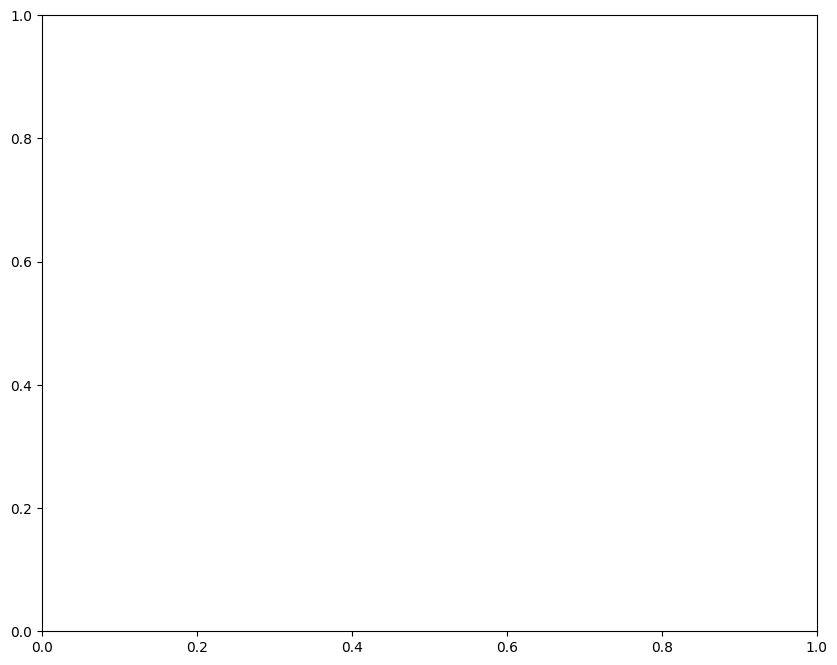

In [57]:
fig = plt.figure(figsize = (10, 8))
ax = fig.add_subplot(111)
for period in set(y_true_c):
    ax.scatter(F[y_true_c == period, 0], F2[y_true_c == period, 1], label=f'{period} - {explain(idx2period[period])}')
fig.legend();

In [58]:
# green
np.where(y_true == 2)

(array([150, 151, 152, 153, 154, 155, 156, 157, 158, 203, 269, 270, 271,
        282, 283, 284, 285, 286, 287, 288, 289, 290, 291, 292, 299, 321,
        322, 323, 324, 332, 340, 342, 355, 359, 360, 361, 362, 363, 364,
        365, 366, 367, 368, 369, 370, 371, 372, 373, 374, 375, 376, 377,
        378, 379, 380, 381, 382, 383, 384, 385, 386, 387, 388, 389, 390,
        391, 392, 393, 394, 395, 396, 397, 398, 399, 400, 401, 402, 403,
        404, 405, 406, 407, 408, 409, 416, 430, 431, 432, 433, 434, 435,
        436, 437, 438, 443, 445, 447, 451, 452, 453, 454, 455, 456, 457,
        458, 465, 467, 468, 469]),)

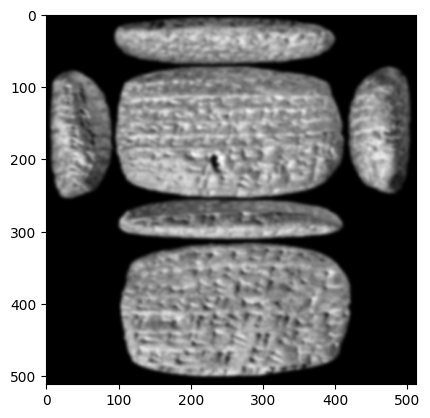

In [59]:
ID = np.random.choice(np.where(y_true == 11)[0])
plt.imshow(ds_test[ID][0], cmap='gray');

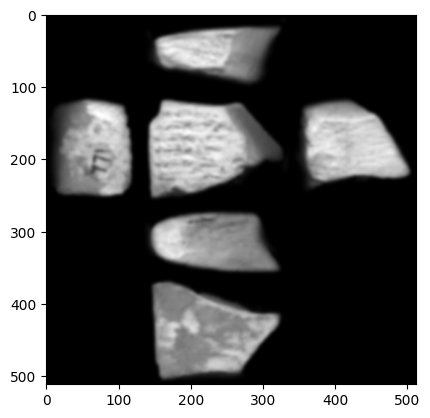

In [60]:
ID = np.random.choice(np.where(y_true == 5)[0])
plt.imshow(ds_test[ID][0], cmap='gray');

In [61]:
F[y_true_c == period, 0]

NameError: name 'F' is not defined

# Visualize mistakes

In [62]:
mistake_indices = np.where(y_true != y_pred)[0]
mistake_indices

array([  1,  16,  44,  59,  65,  92, 115, 116, 117, 118, 126, 131, 138,
       163, 165, 167, 168, 174, 184, 185, 187, 190, 191, 192, 195, 201,
       203, 207, 208, 209, 213, 220, 222, 223, 226, 227, 228, 229, 232,
       233, 236, 238, 242, 243, 244, 246, 247, 249, 253, 259, 266, 268,
       281, 296, 298, 302, 303, 305, 314, 324, 325, 328, 331, 334, 352,
       358, 396, 415, 417, 419, 440, 441, 444, 448, 449, 462, 463, 464,
       466, 473, 482, 483, 484, 486])

In [63]:
mistake_indices.shape

(84,)

In [64]:
for idx in mistake_indices[:5]:
    
    X, y = ds_test[idx]
    pred = y_pred[idx]
    
    plt.imshow(X, cmap='gray')
    plt.title(f'Predicted: {idx2period[pred]}; Ground truth: {idx2period[y]}')
    plt.show()

ValueError: too many values to unpack (expected 2)

# Explain predictions with Lime

https://github.com/marcotcr/lime/blob/master/doc/notebooks/Tutorial%20-%20images%20-%20Pytorch.ipynb

In [65]:
# from lime import lime_image
# from skimage.segmentation import mark_boundaries

In [ ]:
# def preprocess_transform(img):
#     return img

In [ ]:
# def batch_predict(X):
#     assert len(X.shape) == 4
#     # Lime adds channel dimension (gray2rgb); we remove it
#     # it also requires float64 (double) but our model needs float32
#     X_gray = X[..., 0].astype(np.float32) / 255
#     logits = model(torch.tensor(X_gray).to(device)).detach().cpu().numpy()
# #     probs = clf.predict_proba(logits)
#     probs = scipy.special.softmax(logits, axis=-1)
#     return probs

In [ ]:
# explainer = lime_image.LimeImageExplainer()

In [ ]:
# def explain_idx(idx):
#     X, y = ds_test[idx]
    
#     explanation = explainer.explain_instance(
#         X.astype(np.float64) * 255,
#         batch_predict,
#     #     top_labels=3,
#     #     hide_color=0,
#         batch_size=16,
#         num_samples=1000
#     )
    
#     top_label = explanation.top_labels[0]
    
#     temp, mask = explanation.get_image_and_mask(
#         top_label,
#         positive_only=False,
#         num_features=20,
#         hide_rest=False
#     )
    
#     img_boundary = mark_boundaries(temp/255.0, mask)
    
#     print(f'Item {idx}:')
#     print(f'Ground truth:\t{ERAS_SHORT[y]} ({y})')
#     print(f'Prediction:\t{ERAS_SHORT[top_label]} ({top_label})')

#     fig, axs = plt.subplots(1, 2, figsize=(10, 5))
#     axs[0].imshow(X, cmap='gray');
#     axs[1].imshow(img_boundary);
#     plt.show()

In [ ]:
# for i in range(10):
#     explain_idx(i)